# Deblur-V2 圖像去模糊模型


## 步驟 1: 安裝依賴包


In [4]:
!pip install torch torchvision tqdm pillow pretrainedmodels
!pip install pytorch-msssim

import os
import torch
import torch.nn as nn
import torch.optim as optim
from pretrainedmodels import inceptionresnetv2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0c85e14b23b299c8f6c3c0fa94448dc713e9d25ac12382edffd41e11c9768de3
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75dbdfe167a0cb70d3b48913369a00ec5c4e9fed5f2b
Successfully built pretrainedmodels


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/ModelClearify/checkpoints"

### 設置數據集路徑
#defocused_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/kaggle_blur_dataset/kaggle/defocused_blurred'
#motion_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/kaggle_blur_dataset/kaggle/motion_blurred'
#sharp_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/kaggle_blur_dataset/kaggle/sharp'

### GoPro組訓練圖 - 696張
motion_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/kaggle_blur_dataset/GoPro/motion_blur'
sharp_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/kaggle_blur_dataset/GoPro/sharp'

# 創建檢查點目錄
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"✓ 檢查點目錄: {checkpoint_dir}")


✓ 檢查點目錄: /content/drive/MyDrive/Colab Notebooks/ModelClearify/checkpoints


In [7]:
import random
import numpy as np
import torch
from torch.autograd import Variable
from collections import deque


class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        self.sample_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = deque()

    def add(self, images):
        if self.pool_size == 0:
            return images
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
            else:
                self.images.popleft()
                self.images.append(image)

    def query(self):
        if len(self.images) > self.sample_size:
            return_images = list(random.sample(self.images, self.sample_size))
        else:
            return_images = list(self.images)
        return torch.cat(return_images, 0)


## 資料

In [8]:
class DeblurDataset(Dataset):
    def __init__(self, sharp_dir, blur_dir, transform=None, patch_size=512, random_crop_cnt=10):
        self.sharp_dir = sharp_dir
        self.blur_dir = blur_dir
        self.transform = transform
        self.random_crop_cnt = random_crop_cnt
        self.patch_size = patch_size

        blur_files = sorted(os.listdir(blur_dir))
        sharp_files = sorted(os.listdir(sharp_dir))

        def get_id(fname):
            return fname.split('_')[0]

        blur_dict = {get_id(f): f for f in blur_files}
        sharp_dict = {get_id(f): f for f in sharp_files}

        self.paired_keys = sorted(list(set(blur_dict.keys()) & set(sharp_dict.keys())))
        self.blur_dict = blur_dict
        self.sharp_dict = sharp_dict

        self.total_patches = len(self.paired_keys)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return self.total_patches * self.random_crop_cnt

    def __getitem__(self, idx):
        img_idx = idx % self.total_patches
        key = self.paired_keys[img_idx]

        blur_path = os.path.join(self.blur_dir, self.blur_dict[key])
        sharp_path = os.path.join(self.sharp_dir, self.sharp_dict[key])

        blur_img = Image.open(blur_path).convert("RGB")
        sharp_img = Image.open(sharp_path).convert("RGB")
        # 確認兩張圖尺寸相同
        if blur_img.size != sharp_img.size:
            raise ValueError(f"Size mismatch: {blur_path} vs {sharp_path}")

        # --- 尺寸檢查與修正成 32 的倍數 ---
        w, h = blur_img.size
        new_w = (w // 32) * 32
        new_h = (h // 32) * 32
        if new_w != w or new_h != h:
            # print(f"Resizing {key} from ({w},{h}) → ({new_w},{new_h})")
            blur_img = blur_img.resize((new_w, new_h), Image.BICUBIC)
            sharp_img = sharp_img.resize((new_w, new_h), Image.BICUBIC)
            w, h = new_w, new_h

        # --- 裁切 patch ---
        ps = self.patch_size
        if w > ps and h > ps:
            if self.random_crop_cnt > 1:
                x = random.randint(0, w - ps)
                y = random.randint(0, h - ps)
            else:
                x = (w - ps) // 2
                y = (h - ps) // 2
            blur_img = blur_img.crop((x, y, x + ps, y + ps))
            sharp_img = sharp_img.crop((x, y, x + ps, y + ps))
        else:
            # 若比 patch 小，放大成指定大小
            blur_img = blur_img.resize((ps, ps), Image.BICUBIC)
            sharp_img = sharp_img.resize((ps, ps), Image.BICUBIC)

        if self.transform:
          sharp_img = self.transform(sharp_img)
          blur_img = self.transform(blur_img)

        return blur_img, sharp_img, key  # (input, target)

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = DeblurDataset(sharp_dir, motion_dir, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)

# check dateset
# tmp_bar = tqdm(loader, desc=f"Epoch {1}/{1}")
# for i, (blur_img, sharp_img, _) in enumerate(tmp_bar):
#  print(f"\nblur shape: {tuple(blur_img.shape)}, sharp shape: {tuple(sharp_img.shape)}")
#  break  # 只印第一筆可以加快測試

## 模型構建


In [10]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

class FPNHead(nn.Module):
    def __init__(self, num_in, num_mid, num_out):
        super().__init__()

        self.block0 = nn.Conv2d(num_in, num_mid, kernel_size=3, padding=1, bias=False)
        self.block1 = nn.Conv2d(num_mid, num_out, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        x = nn.functional.relu(self.block0(x), inplace=True)
        x = nn.functional.relu(self.block1(x), inplace=True)
        return x

class ConvBlock(nn.Module):
    def __init__(self, num_in, num_out, norm_layer):
        super().__init__()

        self.block = nn.Sequential(nn.Conv2d(num_in, num_out, kernel_size=3, padding=1),
                                 norm_layer(num_out),
                                 nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.block(x)
        return x


class FPNInception(nn.Module):

    def __init__(self, norm_layer=nn.InstanceNorm2d, output_ch=3, num_filters=128, num_filters_fpn=256):
        super().__init__()

        # Feature Pyramid Network (FPN) with four feature maps of resolutions
        # 1/4, 1/8, 1/16, 1/32 and `num_filters` filters for all feature maps.
        self.fpn = FPN(num_filters=num_filters_fpn, norm_layer=norm_layer)

        # The segmentation heads on top of the FPN

        self.head1 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head2 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head3 = FPNHead(num_filters_fpn, num_filters, num_filters)
        self.head4 = FPNHead(num_filters_fpn, num_filters, num_filters)

        self.smooth = nn.Sequential(
            nn.Conv2d(4 * num_filters, num_filters, kernel_size=3, padding=1),
            norm_layer(num_filters),
            nn.ReLU(),
        )

        self.smooth2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters // 2, kernel_size=3, padding=1),
            norm_layer(num_filters // 2),
            nn.ReLU(),
        )

        self.final = nn.Conv2d(num_filters // 2, output_ch, kernel_size=3, padding=1)

    def unfreeze(self):
        self.fpn.unfreeze()

    def forward(self, x):
        map0, map1, map2, map3, map4 = self.fpn(x)

        map4 = nn.functional.interpolate(self.head4(map4), scale_factor=8, mode="nearest")
        map3 = nn.functional.interpolate(self.head3(map3), scale_factor=4, mode="nearest")
        map2 = nn.functional.interpolate(self.head2(map2), scale_factor=2, mode="nearest")
        map1 = nn.functional.interpolate(self.head1(map1), scale_factor=1, mode="nearest")

        smoothed = self.smooth(torch.cat([map4, map3, map2, map1], dim=1))
        smoothed = nn.functional.interpolate(smoothed, scale_factor=2, mode="nearest")
        smoothed = self.smooth2(smoothed + map0)
        smoothed = nn.functional.interpolate(smoothed, scale_factor=2, mode="nearest")

        final = self.final(smoothed)
        res = torch.tanh(final) + x

        return torch.clamp(res, min = -1,max = 1)


class FPN(nn.Module):

    def __init__(self, norm_layer, num_filters=256):
        """Creates an `FPN` instance for feature extraction.
        Args:
          num_filters: the number of filters in each output pyramid level
          pretrained: use ImageNet pre-trained backbone feature extractor
        """

        super().__init__()
        self.inception = inceptionresnetv2(num_classes=1000, pretrained='imagenet')

        self.enc0 = self.inception.conv2d_1a
        self.enc1 = nn.Sequential(
            self.inception.conv2d_2a,
            self.inception.conv2d_2b,
            self.inception.maxpool_3a,
        ) # 64
        self.enc2 = nn.Sequential(
            self.inception.conv2d_3b,
            self.inception.conv2d_4a,
            self.inception.maxpool_5a,
        )  # 192
        self.enc3 = nn.Sequential(
            self.inception.mixed_5b,
            self.inception.repeat,
            self.inception.mixed_6a,
        )   # 1088
        self.enc4 = nn.Sequential(
            self.inception.repeat_1,
            self.inception.mixed_7a,
        ) #2080
        self.td1 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.td2 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.td3 = nn.Sequential(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
                                 norm_layer(num_filters),
                                 nn.ReLU(inplace=True))
        self.pad = nn.ReflectionPad2d(1)
        self.lateral4 = nn.Conv2d(2080, num_filters, kernel_size=1, bias=False)
        self.lateral3 = nn.Conv2d(1088, num_filters, kernel_size=1, bias=False)
        self.lateral2 = nn.Conv2d(192, num_filters, kernel_size=1, bias=False)
        self.lateral1 = nn.Conv2d(64, num_filters, kernel_size=1, bias=False)
        self.lateral0 = nn.Conv2d(32, num_filters // 2, kernel_size=1, bias=False)

        for param in self.inception.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.inception.parameters():
            param.requires_grad = True

    def forward(self, x):

        # Bottom-up pathway, from ResNet
        enc0 = self.enc0(x)

        enc1 = self.enc1(enc0) # 256

        enc2 = self.enc2(enc1) # 512

        enc3 = self.enc3(enc2) # 1024

        enc4 = self.enc4(enc3) # 2048

        # Lateral connections

        lateral4 = self.pad(self.lateral4(enc4))
        lateral3 = self.pad(self.lateral3(enc3))
        lateral2 = self.lateral2(enc2)
        lateral1 = self.pad(self.lateral1(enc1))
        lateral0 = self.lateral0(enc0)

        # Top-down pathway
        pad = (1, 2, 1, 2)  # pad last dim by 1 on each side
        pad1 = (0, 1, 0, 1)
        map4 = lateral4
        map3 = self.td1(lateral3 + nn.functional.interpolate(map4, scale_factor=2, mode="nearest"))
        map2 = self.td2(F.pad(lateral2, pad, "reflect") + nn.functional.interpolate(map3, scale_factor=2, mode="nearest"))
        map1 = self.td3(lateral1 + nn.functional.interpolate(map2, scale_factor=2, mode="nearest"))
        return F.pad(lateral0, pad1, "reflect"), map1, map2, map3, map4

In [11]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np
###############################################################################
# Functions
###############################################################################


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

##############################################################################
# Classes
##############################################################################


# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, use_parallel=True, learn_residual=True, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.use_parallel = use_parallel
        self.learn_residual = learn_residual
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        output = self.model(input)
        if self.learn_residual:
            output = input + output
            output = torch.clamp(output,min = -1,max = 1)
        return output


# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


class DicsriminatorTail(nn.Module):
    def __init__(self, nf_mult, n_layers, ndf=64, norm_layer=nn.BatchNorm2d, use_parallel=True):
        super(DicsriminatorTail, self).__init__()
        self.use_parallel = use_parallel
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = int(np.ceil((kw-1)/2))

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence = [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)


class MultiScaleDiscriminator(nn.Module):
    def __init__(self, input_nc=3, ndf=64, norm_layer=nn.BatchNorm2d, use_parallel=True):
        super(MultiScaleDiscriminator, self).__init__()
        self.use_parallel = use_parallel
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = int(np.ceil((kw-1)/2))
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        for n in range(1, 3):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        self.scale_one = nn.Sequential(*sequence)
        self.first_tail = DicsriminatorTail(nf_mult=nf_mult, n_layers=3)
        nf_mult_prev = 4
        nf_mult = 8

        self.scale_two = nn.Sequential(
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=2, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True))
        nf_mult_prev = nf_mult
        self.second_tail = DicsriminatorTail(nf_mult=nf_mult, n_layers=4)
        self.scale_three = nn.Sequential(
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True))
        self.third_tail = DicsriminatorTail(nf_mult=nf_mult, n_layers=5)

    def forward(self, input):
        x = self.scale_one(input)
        x_1 = self.first_tail(x)
        x = self.scale_two(x)
        x_2 = self.second_tail(x)
        x = self.scale_three(x)
        x = self.third_tail(x)
        return [x_1, x_2, x]


# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc=3, ndf=64, n_layers=3, norm_layer=nn.InstanceNorm2d, use_sigmoid=False, use_parallel=True):
        super(NLayerDiscriminator, self).__init__()
        self.use_parallel = use_parallel
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = int(np.ceil((kw-1)/2))
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)


def get_fullD(model_config):
    model_d = NLayerDiscriminator(n_layers=5,
                                  norm_layer=get_norm_layer(norm_type=model_config['norm_layer']),
                                  use_sigmoid=False)
    return model_d


def get_generator(model_config):
    generator_name = model_config['g_name']
    if generator_name == 'resnet':
        model_g = ResnetGenerator(norm_layer=get_norm_layer(norm_type=model_config['norm_layer']),
                                  use_dropout=model_config['dropout'],
                                  n_blocks=model_config['blocks'],
                                  learn_residual=model_config['learn_residual'])
    elif generator_name == 'fpn_inception':
        model_g = FPNInception(norm_layer=get_norm_layer(norm_type=model_config['norm_layer']))
    elif generator_name == 'fpn_inception_simple':
        model_g = FPN(norm_layer=get_norm_layer(norm_type=model_config['norm_layer']))
    else:
        raise ValueError("Generator Network [%s] not recognized." % generator_name)

    return nn.DataParallel(model_g)


def get_discriminator(model_config):
    discriminator_name = model_config['d_name']
    if discriminator_name == 'no_gan':
        model_d = None
    elif discriminator_name == 'patch_gan':
        model_d = NLayerDiscriminator(n_layers=model_config['d_layers'],
                                      norm_layer=get_norm_layer(norm_type=model_config['norm_layer']),
                                      use_sigmoid=False)
        model_d = nn.DataParallel(model_d)
    elif discriminator_name == 'double_gan':
        patch_gan = NLayerDiscriminator(n_layers=model_config['d_layers'],
                                        norm_layer=get_norm_layer(norm_type=model_config['norm_layer']),
                                        use_sigmoid=False)
        patch_gan = nn.DataParallel(patch_gan)
        full_gan = get_fullD(model_config)
        full_gan = nn.DataParallel(full_gan)
        model_d = {'patch': patch_gan,
                   'full': full_gan}
    elif discriminator_name == 'multi_scale':
        model_d = MultiScaleDiscriminator(norm_layer=get_norm_layer(norm_type=model_config['norm_layer']))
        model_d = nn.DataParallel(model_d)
    else:
        raise ValueError("Discriminator Network [%s] not recognized." % discriminator_name)

    return model_d


def get_nets(model_config):
    return get_generator(model_config), get_discriminator(model_config)

## Loss


In [12]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

###############################################################################
# Functions
###############################################################################

class ContentLoss():
    def initialize(self, loss):
        self.criterion = loss

    def get_loss(self, fakeIm, realIm):
        return self.criterion(fakeIm, realIm)

    def __call__(self, fakeIm, realIm):
        return self.get_loss(fakeIm, realIm)


class PerceptualLoss(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        # 如果没有传 device，就自动判断
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criterion = None
        self.contentFunc = None
        # transform 用于对输入做归一化（在 feature 提取前）
        self.transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def contentFunc_builder(self):
        """构造 VGG 的 feature 提取网络（到 conv_3_3）"""
        conv_3_3_layer = 14  # 选择到第 14 层
        cnn = models.vgg19(pretrained=True).features
        # 把网络移到正确设备
        cnn = cnn.to(self.device)
        # 创建一个新的子网络，包含从第 0 层到第 conv_3_3_layer 层
        model = nn.Sequential()
        model = model.to(self.device)
        model = model.eval()
        for i, layer in enumerate(list(cnn)):
            model.add_module(str(i), layer)
            if i == conv_3_3_layer:
                break
        return model

    def initialize(self, loss_fn):
        # loss_fn 是一个类（例如 nn.MSELoss()、nn.L1Loss() 等）
        # 这里禁止梯度计算
        with torch.no_grad():
            self.criterion = loss_fn
            # 用 builder 方法来得到 contentFunc 网络
            self.contentFunc = self.contentFunc_builder()
            # transform 已在 __init__ 中初始化

    def get_loss(self, fakeIm, realIm):
        # 假设 fakeIm, realIm 在调用前还未做归一化或放置 device
        # 首先把它们移到同一个 device
        fakeIm = fakeIm.to(self.device)
        realIm = realIm.to(self.device)

        # 假定输入范围是 [-1, 1]，先映射到 [0,1]
        fake = (fakeIm + 1.0) / 2.0
        real = (realIm + 1.0) / 2.0

        # 对第一张样本做 transform（归一化）——这里只对 batch 第0 张处理，其它张你可能也要类似做
        # 注意：transform 是对单张图像 (C, H, W) 的操作
        fake[0] = self.transform(fake[0])
        real[0] = self.transform(real[0])

        # 提取特征
        f_fake = self.contentFunc(fake)
        f_real = self.contentFunc(real)
        f_real_detach = f_real.detach()

        # 计算感知损失
        loss_content = self.criterion(f_fake, f_real_detach)

        # 再加上像素级损失：MSE(fake, real)
        pixel_loss = nn.MSELoss()(fake, real)

        # 返回加权的总损失（你原来是 0.006 * content + 0.5 * mse）
        return 0.006 * torch.mean(loss_content) + 0.5 * pixel_loss

    def forward(self, fakeIm, realIm):
        return self.get_loss(fakeIm, realIm)


class GANLoss(nn.Module):
    def __init__(self, use_l1=True, target_real_label=1.0, target_fake_label=0.0,
                 tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        self.Tensor = tensor
        if use_l1:
            self.loss = nn.L1Loss()
        else:
            self.loss = nn.BCEWithLogitsLoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = self.Tensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor.cuda()

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)


class DiscLoss(nn.Module):
    def name(self):
        return 'DiscLoss'

    def __init__(self):
        super(DiscLoss, self).__init__()

        self.criterionGAN = GANLoss(use_l1=False)
        self.fake_AB_pool = ImagePool(50)

    def get_g_loss(self, net, fakeB, realB):
        # First, G(A) should fake the discriminator
        pred_fake = net.forward(fakeB)
        return self.criterionGAN(pred_fake, 1)

    def get_loss(self, net, fakeB, realB):
        # Fake
        # stop backprop to the generator by detaching fake_B
        # Generated Image Disc Output should be close to zero
        self.pred_fake = net.forward(fakeB.detach())
        self.loss_D_fake = self.criterionGAN(self.pred_fake, 0)

        # Real
        self.pred_real = net.forward(realB)
        self.loss_D_real = self.criterionGAN(self.pred_real, 1)

        # Combined loss
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        return self.loss_D

    def __call__(self, net, fakeB, realB):
        return self.get_loss(net, fakeB, realB)


class RelativisticDiscLoss(nn.Module):
    def name(self):
        return 'RelativisticDiscLoss'

    def __init__(self):
        super(RelativisticDiscLoss, self).__init__()

        self.criterionGAN = GANLoss(use_l1=False)
        self.fake_pool = ImagePool(50)  # create image buffer to store previously generated images
        self.real_pool = ImagePool(50)

    def get_g_loss(self, net, fakeB, realB):
        # First, G(A) should fake the discriminator
        self.pred_fake = net.forward(fakeB)

        # Real
        self.pred_real = net.forward(realB)
        errG = (self.criterionGAN(self.pred_real - torch.mean(self.fake_pool.query()), 0) +
                self.criterionGAN(self.pred_fake - torch.mean(self.real_pool.query()), 1)) / 2
        return errG

    def get_loss(self, net, fakeB, realB):
        # Fake
        # stop backprop to the generator by detaching fake_B
        # Generated Image Disc Output should be close to zero
        self.fake_B = fakeB.detach()
        self.real_B = realB
        self.pred_fake = net.forward(fakeB.detach())
        self.fake_pool.add(self.pred_fake)

        # Real
        self.pred_real = net.forward(realB)
        self.real_pool.add(self.pred_real)

        # Combined loss
        self.loss_D = (self.criterionGAN(self.pred_real - torch.mean(self.fake_pool.query()), 1) +
                       self.criterionGAN(self.pred_fake - torch.mean(self.real_pool.query()), 0)) / 2
        return self.loss_D

    def __call__(self, net, fakeB, realB):
        return self.get_loss(net, fakeB, realB)

class DiscLossLS(DiscLoss):
    def name(self):
        return 'DiscLossLS'

    def __init__(self):
        super(DiscLossLS, self).__init__()
        self.criterionGAN = GANLoss(use_l1=True)

    def get_g_loss(self, net, fakeB, realB):
        return DiscLoss.get_g_loss(self, net, fakeB)

    def get_loss(self, net, fakeB, realB):
        return DiscLoss.get_loss(self, net, fakeB, realB)


class DiscLossWGANGP(DiscLossLS):
    def name(self):
        return 'DiscLossWGAN-GP'

    def __init__(self):
        super(DiscLossWGANGP, self).__init__()
        self.LAMBDA = 10

    def get_g_loss(self, net, fakeB, realB):
        # First, G(A) should fake the discriminator
        self.D_fake = net.forward(fakeB)
        return -self.D_fake.mean()

    def calc_gradient_penalty(self, netD, real_data, fake_data):
        alpha = torch.rand(1, 1)
        alpha = alpha.expand(real_data.size())
        alpha = alpha.cuda()

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        interpolates = interpolates.cuda()
        interpolates = Variable(interpolates, requires_grad=True)

        disc_interpolates = netD.forward(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.LAMBDA
        return gradient_penalty

    def get_loss(self, net, fakeB, realB):
        self.D_fake = net.forward(fakeB.detach())
        self.D_fake = self.D_fake.mean()

        # Real
        self.D_real = net.forward(realB)
        self.D_real = self.D_real.mean()
        # Combined loss
        self.loss_D = self.D_fake - self.D_real
        gradient_penalty = self.calc_gradient_penalty(net, realB.data, fakeB.data)
        return self.loss_D + gradient_penalty


def get_loss(model):
    if model['content_loss'] == 'perceptual':
        content_loss = PerceptualLoss()
        content_loss.initialize(nn.MSELoss())
    elif model['content_loss'] == 'l1':
        content_loss = ContentLoss()
        content_loss.initialize(nn.L1Loss())
    else:
        raise ValueError("ContentLoss [%s] not recognized." % model['content_loss'])

    if model['disc_loss'] == 'wgan-gp':
        disc_loss = DiscLossWGANGP()
    elif model['disc_loss'] == 'lsgan':
        disc_loss = DiscLossLS()
    elif model['disc_loss'] == 'gan':
        disc_loss = DiscLoss()
    elif model['disc_loss'] == 'ragan':
        disc_loss = RelativisticDiscLoss()
    else:
        raise ValueError("GAN Loss [%s] not recognized." % model['disc_loss'])
    return content_loss, disc_loss

In [13]:
class RelativisticAverageLSGAN(nn.Module):
    def __init__(self):
        super(RelativisticAverageLSGAN, self).__init__()
        self.criterion = nn.MSELoss()

    def D_loss(self, pred_real, pred_fake):
        real_loss = self.criterion(pred_real - pred_fake.mean(), torch.ones_like(pred_real))
        fake_loss = self.criterion(pred_fake - pred_real.mean(), torch.zeros_like(pred_fake))
        return 0.5 * (real_loss + fake_loss)

    def G_loss(self, pred_real, pred_fake):
        real_loss = self.criterion(pred_real - pred_fake.mean(), torch.zeros_like(pred_real))
        fake_loss = self.criterion(pred_fake - pred_real.mean(), torch.ones_like(pred_fake))
        return 0.5 * (real_loss + fake_loss)

In [14]:
def relativistic_loss_D(real_pred, fake_pred):
    # real_pred, fake_pred 為 Discriminator 判別輸出
    # 這是 D 的損失：希望 D(real, fake) 大於 D(fake, real)
    # 此為 LSGAN 形式
    # L_D = 0.5 * ( (real_pred - torch.mean(fake_pred) - 1)**2 + (fake_pred - torch.mean(real_pred) + 1)**2 )
    loss_real = torch.mean((real_pred - torch.mean(fake_pred) - 1) ** 2)
    loss_fake = torch.mean((fake_pred - torch.mean(real_pred) + 1) ** 2)
    return 0.5 * (loss_real + loss_fake)

def relativistic_loss_G(real_pred, fake_pred):
    # G 的損失：希望 fake 更真實
    # L_G = 0.5 * ( (real_pred - torch.mean(fake_pred) + 1)**2 + (fake_pred - torch.mean(real_pred) - 1)**2 )
    loss_real = torch.mean((real_pred - torch.mean(fake_pred) + 1) ** 2)
    loss_fake = torch.mean((fake_pred - torch.mean(real_pred) - 1) ** 2)
    return 0.5 * (loss_real + loss_fake)

## PSNR/ SSIM

In [15]:
import torch
import torch.nn.functional as F
from math import log10
from pytorch_msssim import ssim as ssim_fn  # pip install pytorch-msssim

def compute_psnr(fake, real):
    """Peak Signal-to-Noise Ratio"""
    mse = F.mse_loss(fake, real)
    if mse == 0:
        return 100
    return 10 * log10(1.0 / mse.item())

def compute_ssim(fake, real):
    """Structural Similarity Index"""
    # pytorch_msssim expects (B,C,H,W), value range [0,1]
    return ssim_fn(fake, real, data_range=1.0, size_average=True).item()


## Train

In [16]:
G = FPNInception( norm_layer=nn.InstanceNorm2d ).to(device)
# 全图鉴别
D_global = NLayerDiscriminator(
    input_nc=3, ndf=64, n_layers=5,
    norm_layer=nn.InstanceNorm2d,
    use_sigmoid=False
).to(device)

# 局部 patch 鉴别
D_local = NLayerDiscriminator(
    input_nc=3, ndf=64, n_layers=5,
    norm_layer=nn.InstanceNorm2d,
    use_sigmoid=False
).to(device)

opt_G = optim.Adam( G.parameters(), lr=5e-5, betas=(0.5, 0.999))
opt_D = optim.Adam( list(D_global.parameters()) + list(D_local.parameters()), lr=5e-5, betas=(0.5, 0.999))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth


100%|██████████| 213M/213M [00:10<00:00, 21.7MB/s]


In [ ]:

# =========================================================
# 4️⃣ Checkpoint 設定
# =========================================================
ckpt_dir = checkpoint_dir
os.makedirs(ckpt_dir, exist_ok=True)
start_epoch = 0

adversarial_loss = RelativisticAverageLSGAN().to(device)
perceptual_loss = PerceptualLoss().to(device)
perceptual_loss.initialize(nn.L1Loss())
pixel_loss = nn.L1Loss()

# 如果有 checkpoint 就自動載入
ckpt_path = os.path.join(ckpt_dir, "deblurgan_v2_latest.pth")
if os.path.exists(ckpt_path):
    print(f"🔄 Loading checkpoint from {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=device)
    G.load_state_dict(ckpt["G"])
    D_global.load_state_dict(ckpt["D_global"])
    D_local.load_state_dict(ckpt["D_local"])
    opt_G.load_state_dict(ckpt["optim_G"])
    opt_D.load_state_dict(ckpt["optim_D"])
    start_epoch = ckpt["epoch"] + 1
    print(f"✅ Resume training from epoch {start_epoch}")

g_losses = []
d_losses = []
psnr_list = []
ssim_list = []

metrics_path = os.path.join(ckpt_dir, "metrics_latest.pth")
if os.path.exists(metrics_path):
    print(f"🔄 Loading checkpoint from {metrics_path}")
    metrics_pt = torch.load(metrics_path, map_location=device)
    g_losses = metrics_pt["g_losses"]
    d_losses = metrics_pt["d_losses"]
    psnr_list = metrics_pt["psnr_list"]
    ssim_list = metrics_pt["ssim_list"]
    print(f"Loaded metrics — {len(g_losses)} epochs")

# -----------------------------
# 1) 定義官方預設的 λ 值
# -----------------------------
lambda_L1    = 1.0    # L1 重建 loss 權重
lambda_perc  = 0.05      # perceptual loss 權重
lambda_gan   = 5e-3     # adv loss 權重

patch_size = 128  # 可根据图像大小调整
num_epochs = 2
for epoch in range(start_epoch, num_epochs):
  G.train()
  D_global.train()
  D_local.train()

  running_g_loss = 0.0
  running_d_loss = 0.0
  pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}")

  for i, (blur_img, sharp_img, _) in enumerate(pbar):
    blur_img = blur_img.to(device)
    sharp_img = sharp_img.to(device)

    # ---------------------
    # 1) 训练 Discriminator (Global + Local)
    # ---------------------
    opt_D.zero_grad()
    with torch.no_grad():
        fake_img = G(blur_img)

    # 1.1 全图鉴别
    pred_real_g = D_global(sharp_img)
    pred_fake_g = D_global(fake_img)

    # 1.2 随机裁切同一个位置的局部 patch
    B, C, H, W = sharp_img.shape
    i = torch.randint(0, H - patch_size + 1, (1,)).item()
    j = torch.randint(0, W - patch_size + 1, (1,)).item()
    real_patch = sharp_img[:, :, i:i+patch_size, j:j+patch_size]
    fake_patch = fake_img[:, :, i:i+patch_size, j:j+patch_size]
    pred_real_l = D_local(real_patch)
    pred_fake_l = D_local(fake_patch)

    # 1.3 计算两个 Discriminator 的 Relativistic loss 并求平均
    loss_dg = adversarial_loss.D_loss(pred_real_g, pred_fake_g)
    loss_dl = adversarial_loss.D_loss(pred_real_l, pred_fake_l)
    loss_d  = 0.5 * (loss_dg + loss_dl)

    loss_d.backward()
    opt_D.step()

    # ---------------------
    # 2) 训练 Generator
    # ---------------------
    opt_G.zero_grad()
    fake_img = G(blur_img)

    # 2.1 重新计算 Global baseline（detach）与 fake
    pred_real_g = D_global(sharp_img).detach()
    pred_fake_g = D_global(fake_img)
    loss_g_g   = adversarial_loss.G_loss(pred_real_g, pred_fake_g)

    # 2.2 重新裁切同样的位置，计算 Local baseline 与 fake
    real_patch = sharp_img[:, :, i:i+patch_size, j:j+patch_size]
    fake_patch = fake_img[:, :, i:i+patch_size, j:j+patch_size]
    pred_real_l = D_local(real_patch).detach()
    pred_fake_l = D_local(fake_patch)
    loss_g_l    = adversarial_loss.G_loss(pred_real_l, pred_fake_l)

    # 2.3 平均两路 adversarial loss
    loss_g_adv = 0.5 * (loss_g_g + loss_g_l)

    # 2.4 Content Loss
    loss_l1   = pixel_loss(fake_img, sharp_img)
    loss_perc = perceptual_loss(fake_img, sharp_img)

    # 2.5 总 Generator Loss
    loss_g = lambda_gan  * loss_g_adv + lambda_L1   * loss_l1 + lambda_perc * loss_perc

    loss_g.backward()
    opt_G.step()

    # ---------------------
    # Metrics
    # ---------------------
    psnr_val = compute_psnr(fake_img.detach(), sharp_img)
    ssim_val = compute_ssim(fake_img.detach(), sharp_img)

    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)

    # ---------------------
    # 更新 Running Loss
    # ---------------------
    running_g_loss += loss_g.item()
    running_d_loss += loss_d.item()
    pbar.set_postfix({
        "Loss_G": f"{loss_g.item():.4f}",
        "Loss_D": f"{loss_d.item():.4f}",
        "PSNR": f"{psnr_val:.2f}",
        "SSIM": f"{ssim_val:.3f}"
    })

  # 平均 Loss
  avg_g = running_g_loss / len(loader)
  avg_d = running_d_loss / len(loader)

  avg_psnr = sum(psnr_list)/len(psnr_list)
  avg_ssim = sum(ssim_list)/len(ssim_list)
  print(f"[Epoch {epoch+1}] PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

  g_losses.append(avg_g)
  d_losses.append(avg_d)

  # -----------------------------
  # Save checkpoint
  # -----------------------------
  torch.save({
      "epoch": epoch,
      "G": G.state_dict(),
      "D_global": D_global.state_dict(),
      "D_local": D_local.state_dict(),
      "optim_G": opt_G.state_dict(),
      "optim_D": opt_D.state_dict()
  }, ckpt_path)
  print(f"✅ Checkpoint saved to {ckpt_path}")

  torch.save({
      "g_losses": g_losses,
      "d_losses": d_losses,
      "psnr_list": psnr_list,
      "ssim_list": ssim_list
  }, metrics_path)
  print(f"✅ Loss Metrics saved to {metrics_path}")

print("🎉 Training finished!")
# -----------------------------
# 可視化 Loss 曲線
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# ==============================
# 2️⃣ PSNR / SSIM 曲線
# ==============================
plt.figure(figsize=(8,4))
plt.plot(psnr_list, label='PSNR (dB)')
plt.plot(ssim_list, label='SSIM')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Image Quality Metrics')
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 83.4MB/s]
Epoch 1/2:  57%|█████▋    | 989/1740 [20:53<15:39,  1.25s/it, Loss_G=0.0624, Loss_D=0.3312, PSNR=19.68, SSIM=0.705]

## Load Loss Metric

In [ ]:
metrics_path = checkpoint_dir + "/metrics_latest.pth"
metrics_pt = torch.load(metrics_path, map_location=device)
latest_g_losses = metrics_pt["g_losses"]
latest_d_losses = metrics_pt["d_losses"]
latest_psnr_list = metrics_pt["psnr_list"]
latest_ssim_list = metrics_pt["ssim_list"]

# ----------------------------
# 1️⃣ Loss 曲線
# ----------------------------
plt.figure(figsize=(8,4))
plt.plot(latest_g_losses, label='Generator Loss', color='tab:red')
plt.plot(latest_d_losses, label='Discriminator Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 2️⃣ PSNR / SSIM 曲線
# ----------------------------
plt.figure(figsize=(8,4))
plt.plot(latest_psnr_list, label='PSNR (dB)', color='tab:blue')
plt.plot(latest_ssim_list, label='SSIM', color='tab:green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Image Quality Metrics')
plt.legend()
plt.tight_layout()
plt.show()

## Test

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ 初始化模型架構（與訓練時相同）
G = FPNInception( norm_layer=nn.InstanceNorm2d ).to(device)

# 2️⃣ 載入 checkpoint
ckpt_path = checkpoint_dir + "/deblurgan_v2_latest.pth"

checkpoint = torch.load(ckpt_path, map_location=device)
missing, unexpected = G.load_state_dict(checkpoint["G"], strict=False)

#G.eval()  # 推論模式
print("✅ Model loaded from", ckpt_path)

✅ Model loaded from /content/drive/MyDrive/Colab Notebooks/ModelClearify/checkpoints/deblurgan_v2_latest.pth


In [ ]:
def deblur_image_tiled(model, img, device, tile_size=512, overlap=32):
    """
    用 tile-based 方法在 GPU 記憶體有限時推論整張大圖。
    Args:
        model: 已載入權重的 DeblurGAN-v2 Generator
        img: 要處理的影像
        device: torch.device("cuda" or "cpu")
        tile_size: 每塊大小（建議 512）
        overlap: 重疊區域像素數（建議 16~64）
    """
    model.eval() # 推論模式

    # ---- 預處理 ----
    w, h = img.size

    # 確保為 32 倍數
    new_w = (w // 32) * 32
    new_h = (h // 32) * 32
    if new_w != w or new_h != h:
        img = img.resize((new_w, new_h), Image.BICUBIC)
        w, h = new_w, new_h

    img_np = np.array(img).astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)

    # ---- 計算 tile 網格 ----
    stride = tile_size - overlap
    tiles_x = list(range(0, w, stride))
    tiles_y = list(range(0, h, stride))
    if tiles_x[-1] + tile_size > w:
        tiles_x[-1] = w - tile_size
    if tiles_y[-1] + tile_size > h:
        tiles_y[-1] = h - tile_size

    # ---- 準備空白輸出與權重 ----
    output = torch.zeros_like(img_tensor)
    weight = torch.zeros_like(img_tensor)

    with torch.no_grad():
        for y in tiles_y:
            for x in tiles_x:
                patch = img_tensor[:, :, y:y+tile_size, x:x+tile_size]
                pred = model(patch)

                # 疊加到對應位置
                output[:, :, y:y+tile_size, x:x+tile_size] += pred
                weight[:, :, y:y+tile_size, x:x+tile_size] += 1.0

    # ---- 平均化（避免重疊區域過曝）----
    output /= weight
    output = torch.clamp(output, 0, 1)

    # ---- 轉回圖片 ----
    out_np = (output.squeeze().permute(1, 2, 0).cpu().numpy() * 255.0).astype(np.uint8)
    out_img = Image.fromarray(out_np)
    return out_img

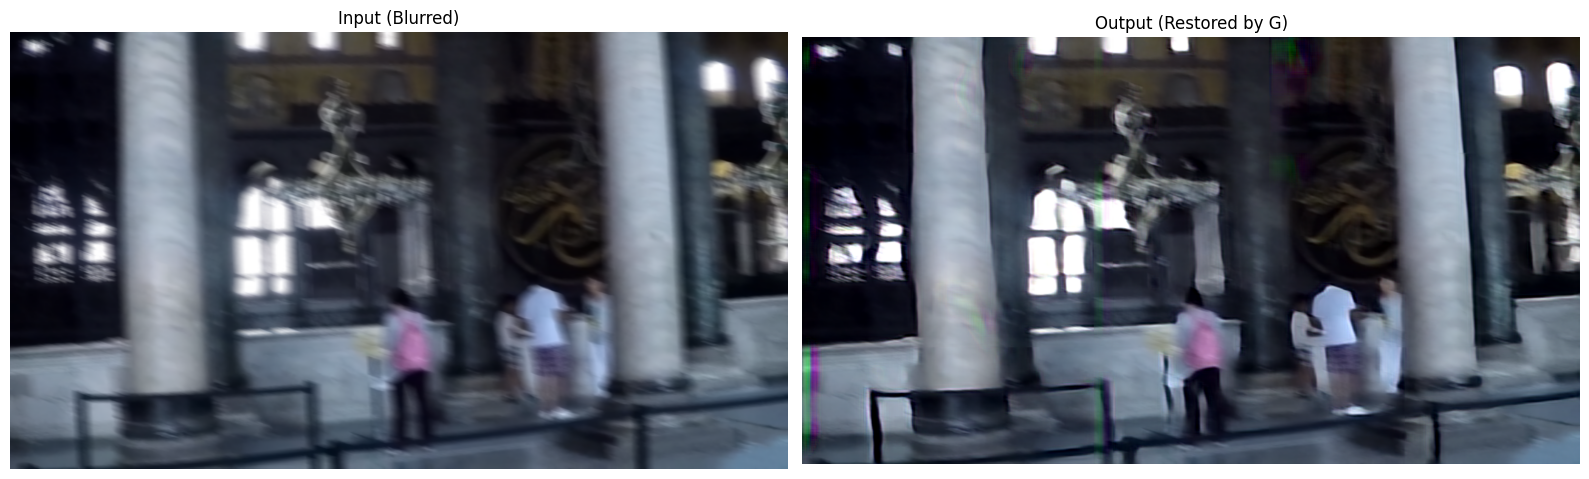

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 讀取要超解析的圖片
input_path = motion_dir + "/000_GOPR0372_07_00_000047.png"  # 你自己的路徑
img = Image.open(input_path).convert("RGB")

out_img = deblur_image_tiled( G, img, device, tile_size=512, overlap=32)

# ============
# 4️⃣ 顯示結果
# ============
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input (Blurred)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.title("Output (Restored by G)")
plt.axis("off")

plt.tight_layout()   # 自動調整子圖間距
plt.show()
